In [2]:
import numpy as np 
import pandas as pd 
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from segmentation_models_pytorch import Unet

In [3]:
#transforms
newsize = (256, 256)
#dataset
fold = 1
#dataloader
batch_size = 64
num_workers = 4
#model
num_classes = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#run
epochs = 50
learning_rate = 1e-3

TRAIN = True #or  False for inference only

### Model

### Create folds

In [ ]:
output_dir = "/input/spider-mri-spine-t2-png/data"
im_dir = os.path.join(output_dir, "images")
mask_dir = os.path.join(output_dir, "masks")

# get list of data
items = list(Path(im_dir).glob("*.png"))
image_names = [o.name for o in items]
images = list(set([o.split('_')[0] for o in image_names]))

fold_df = pd.DataFrame({"image_name": images})
# Seed for reproducibility
np.random.seed(42)

# Split the DataFrame into 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (_, v_ind) in enumerate(kf.split(fold_df)):
    fold_df.loc[v_ind, 'fold'] = i+1

# Create df with image_names and their respective folds
def get_fold(fn, df):
    image_name = fn.name.split("_")[0] 
    return df.loc[df.image_name==image_name, 'fold'].values[0]

folds = [get_fold(o, fold_df) for o in items]
df = pd.DataFrame({"image": image_names, "fold": folds})

df.head()

,image,fold
0,10_11.png,5.0
1,191_01.png,1.0
2,210_06.png,3.0
3,239_03.png,4.0
4,61_01.png,1.0


In [5]:
test_df=df[df['fold']==5]
train_df=df[df['fold']!=5]
len(train_df),len(test_df)

(2831, 704)

### Dataset class

In [6]:
class SEGDataset(Dataset):
    def __init__(self, df, mode, transforms=None):
        self.df = df.reset_index()
        self.mode = mode
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]

        image_path = os.path.join(im_dir, row.image)
        mask_path = os.path.join(mask_dir, row.image)

        # Open image
        image = Image.open(image_path).convert('L')
        image = np.asarray(image)
        if (image > 1).any():  # Normalize if pixel values are between 0-255
            image = image / 255.0

        # Open mask
        mask = Image.open(mask_path)
        mask = np.asarray(mask)
        mask= np.where(mask<=5,mask,0) #considering only L5,L4,L3,L2,L1 vertebrae's
        assert mask.max() < num_classes, f"Mask value {mask.max()} exceeds number of classes {num_classes}"

        # Apply transformations
        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        
        # Create one layer for each label
        mask = torch.as_tensor(mask).long()
        mask = torch.nn.functional.one_hot(mask, num_classes=num_classes).permute(2,0,1).float()
        #mask = torch.nn.functional.one_hot(mask, num_classes=num_classes).permute(0,3,1,2).squeeze(0).float()

        # Convert image to tensor
        image = torch.as_tensor(image).float()

        return image, mask          

### Transforms

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transforms_train = A.Compose([
    A.Resize(newsize[0], newsize[1]),
    A.HorizontalFlip(),
    A.Normalize(
        mean=[0.485],
        std=[0.229],
    ),
    ToTensorV2()
])

transforms_valid = A.Compose([
    A.Resize(newsize[0], newsize[1]),
    A.Normalize(
        mean=[0.485],
        std=[0.229],
    ),
    ToTensorV2()
])

### Loss
A combined loss function with cross-entropy loss and jaccard loss is created 

In [8]:
class CombinedLoss(nn.Module):
    def __init__(self, weight_ce=0.4, weight_iou=0.6):
        super(CombinedLoss, self).__init__()
        self.weight_ce = weight_ce
        self.weight_iou = weight_iou
        self.cross_entropy_loss = nn.CrossEntropyLoss(reduction='mean')

    def forward(self, inputs, targets):
        # Cross-Entropy Loss
        ce_loss = self.cross_entropy_loss(inputs, targets.argmax(dim=1))

        # IoU Loss
        probs = F.softmax(inputs, dim=1)
        intersection = torch.sum(probs * targets, dim=(2, 3))
        union = torch.sum(probs, dim=(2, 3)) + torch.sum(targets, dim=(2, 3)) - intersection
        iou = (intersection + 1e-6) / (union + 1e-6)
        iou_loss = 1 - iou.mean(dim=1)  # Average over classes, resulting in (batch_size,)

        # Combine losses
        loss = self.weight_ce * ce_loss + self.weight_iou * iou_loss.mean()
        return loss

### Create datasets and dataloaders

In [9]:
train_ = train_df[train_df['fold'] != fold].reset_index(drop=True)
valid_ = train_df[train_df['fold'] == fold].reset_index(drop=True)
print(len(train_),len(valid_))
dataset_train = SEGDataset(train_, 'train',  transforms_train)
dataset_valid = SEGDataset(valid_, 'valid',  transforms_valid)
dataset_test  = SEGDataset(test_df,  'valid',  transforms_valid)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

2108 723


### Run function

In [10]:
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

def run(train_loader, val_loader, model, learning_rate, criterion, epochs, device):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    best_val_loss=float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as train_bar:
            for images, masks in train_bar:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                #train_bar.set_postfix({"Train Loss": loss.item()})
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            with tqdm(val_loader, desc="Validation", unit="batch") as val_bar:
                for images, masks in val_bar:
                    images, masks = images.to(device), masks.to(device)
                    outputs = model(images)
                    val_loss += criterion(outputs, masks).item()
                    
        val_loss /= len(val_loader)
        if best_val_loss>val_loss:
            print('Saving model...')
            best_val_loss=val_loss
            torch.save(model.state_dict(), './simple_unet.pth')

        scheduler.step(val_loss)
        print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    

In [11]:
model = Unet(
  encoder_name="resnet34",  # Choose encoder (e.g. resnet18, efficientnet-b0)
  classes=num_classes,  # Number of output classes
  in_channels=1  # Number of input channels (e.g. 3 for RGB)
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 211MB/s] 


### Train

In [12]:
criterion = CombinedLoss()
model.to(device)

if TRAIN:
    run(train_loader, val_loader, model, learning_rate, criterion, epochs, device)
else:
    model.load_state_dict(torch.load("/kaggle/input/lumbar-vertebrae-segmentation/pytorch/default/1/simple_unet.pth"))
                      

Validation: 100%|██████████| 12/12 [00:07<00:00,  1.66batch/s]


Saving model...
Epoch: 1/50 | Train Loss: 0.8235 | Val Loss: 1.0185


Validation: 100%|██████████| 12/12 [00:06<00:00,  2.00batch/s]


Saving model...
Epoch: 2/50 | Train Loss: 0.5182 | Val Loss: 0.6363


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.05batch/s]


Saving model...
Epoch: 3/50 | Train Loss: 0.4154 | Val Loss: 0.5872


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04batch/s]


Epoch: 4/50 | Train Loss: 0.3286 | Val Loss: 0.6147


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.03batch/s]


Saving model...
Epoch: 5/50 | Train Loss: 0.2811 | Val Loss: 0.5602


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04batch/s]


Epoch: 6/50 | Train Loss: 0.2463 | Val Loss: 0.6529


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.89batch/s]


Epoch: 7/50 | Train Loss: 0.2161 | Val Loss: 0.6599


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.97batch/s]


Epoch: 8/50 | Train Loss: 0.1971 | Val Loss: 0.6736


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08batch/s]


Epoch: 9/50 | Train Loss: 0.1924 | Val Loss: 0.6880


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.02batch/s]


Epoch: 10/50 | Train Loss: 0.1888 | Val Loss: 0.6883


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.95batch/s]


Epoch 00011: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 11/50 | Train Loss: 0.1801 | Val Loss: 0.6893


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.97batch/s]


Epoch: 12/50 | Train Loss: 0.1679 | Val Loss: 0.6861


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.84batch/s]


Saving model...
Epoch: 13/50 | Train Loss: 0.1624 | Val Loss: 0.2929


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.85batch/s]


Epoch: 14/50 | Train Loss: 0.1599 | Val Loss: 0.6191


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.87batch/s]


Epoch: 15/50 | Train Loss: 0.1581 | Val Loss: 0.4408


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.02batch/s]


Saving model...
Epoch: 16/50 | Train Loss: 0.1562 | Val Loss: 0.2494


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.01batch/s]


Saving model...
Epoch: 17/50 | Train Loss: 0.1554 | Val Loss: 0.2134


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07batch/s]


Epoch: 18/50 | Train Loss: 0.1552 | Val Loss: 0.4111


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.86batch/s]


Epoch: 19/50 | Train Loss: 0.1533 | Val Loss: 0.2251


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09batch/s]


Epoch: 20/50 | Train Loss: 0.1523 | Val Loss: 0.2364


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08batch/s]


Epoch: 21/50 | Train Loss: 0.1513 | Val Loss: 0.2509


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04batch/s]


Epoch: 22/50 | Train Loss: 0.1508 | Val Loss: 0.7094


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.98batch/s]


Epoch 00023: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 23/50 | Train Loss: 0.1493 | Val Loss: 0.3119


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82batch/s]


Saving model...
Epoch: 24/50 | Train Loss: 0.1483 | Val Loss: 0.2058


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04batch/s]


Saving model...
Epoch: 25/50 | Train Loss: 0.1481 | Val Loss: 0.1743


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.02batch/s]


Epoch: 26/50 | Train Loss: 0.1478 | Val Loss: 0.1842


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.03batch/s]


Epoch: 27/50 | Train Loss: 0.1475 | Val Loss: 0.1849


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.96batch/s]


Saving model...
Epoch: 28/50 | Train Loss: 0.1472 | Val Loss: 0.1734


Validation: 100%|██████████| 12/12 [00:06<00:00,  2.00batch/s]


Saving model...
Epoch: 29/50 | Train Loss: 0.1470 | Val Loss: 0.1732


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.81batch/s]


Epoch: 30/50 | Train Loss: 0.1471 | Val Loss: 0.1738


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.01batch/s]


Epoch: 31/50 | Train Loss: 0.1465 | Val Loss: 0.1751


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.98batch/s]


Epoch: 32/50 | Train Loss: 0.1467 | Val Loss: 0.1787


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.02batch/s]


Epoch: 33/50 | Train Loss: 0.1467 | Val Loss: 0.1744


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09batch/s]


Epoch: 34/50 | Train Loss: 0.1467 | Val Loss: 0.1786


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.96batch/s]


Saving model...
Epoch: 35/50 | Train Loss: 0.1467 | Val Loss: 0.1727


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.02batch/s]


Epoch: 36/50 | Train Loss: 0.1461 | Val Loss: 0.1735


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.02batch/s]


Epoch: 37/50 | Train Loss: 0.1465 | Val Loss: 0.1800


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.02batch/s]


Epoch: 38/50 | Train Loss: 0.1460 | Val Loss: 0.1755


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.02batch/s]


Epoch: 39/50 | Train Loss: 0.1458 | Val Loss: 0.1758


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.02batch/s]


Epoch: 40/50 | Train Loss: 0.1458 | Val Loss: 0.1730


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.94batch/s]


Epoch 00041: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 41/50 | Train Loss: 0.1457 | Val Loss: 0.1819


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.01batch/s]


Epoch: 42/50 | Train Loss: 0.1457 | Val Loss: 0.1727


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09batch/s]


Epoch: 43/50 | Train Loss: 0.1456 | Val Loss: 0.1727


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.01batch/s]


Saving model...
Epoch: 44/50 | Train Loss: 0.1456 | Val Loss: 0.1726


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.98batch/s]


Epoch: 45/50 | Train Loss: 0.1454 | Val Loss: 0.1727


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.01batch/s]


Saving model...
Epoch: 46/50 | Train Loss: 0.1461 | Val Loss: 0.1725


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.86batch/s]


Epoch: 47/50 | Train Loss: 0.1455 | Val Loss: 0.1729


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.01batch/s]


Epoch: 48/50 | Train Loss: 0.1453 | Val Loss: 0.1727


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.01batch/s]


Epoch: 49/50 | Train Loss: 0.1454 | Val Loss: 0.1731


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.02batch/s]

Epoch: 50/50 | Train Loss: 0.1450 | Val Loss: 0.1727


### Inference

In [13]:
import matplotlib.pyplot as plt

def inference(model, dataloader, device, num_samples=16):
    model.eval()
    images_batch = []
    preds_batch = []
    
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            images_batch.append(images.cpu())
            preds_batch.append(preds.cpu())
            
            if len(images_batch) * images.size(0) >= num_samples:
                break

    images_batch = torch.cat(images_batch)[:num_samples]
    preds_batch = torch.cat(preds_batch)[:num_samples]
    
    return images_batch, preds_batch


# Define a color map with fixed colors for each label
def get_label_colors(num_classes):
    colors = plt.cm.tab20(np.linspace(0, 1, num_classes))
    return colors

def visualize_predictions(images, masks, num_classes=6, num_samples=16):
    num_samples = min(num_samples, len(images))
    plt.figure(figsize=(10,10))
    
    label_colors = get_label_colors(num_classes)
    
    for i in range(num_samples):
        plt.subplot(4, 2, i * 2 + 1)
        im = images[i].numpy()
        im = np.transpose(im, (1, 2, 0))
        #denormalize
        im = ((im * [0.229]) + [0.485]) * 255
        plt.imshow(im,cmap='gray')
        plt.title("Input Image")
        plt.axis('off')
        
        plt.subplot(4, 2, i * 2 + 2)
        mask = masks[i].numpy()

        color_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
        for label in range(num_classes):
            color_mask[mask == label] = label_colors[label][:3] * 255
        
        plt.imshow(color_mask.astype(np.uint8))
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.show()

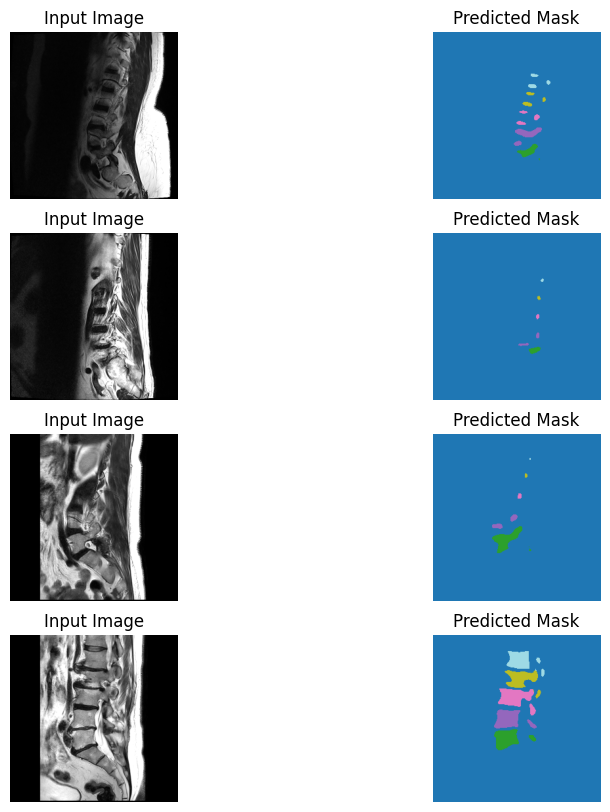

In [14]:
model.eval()
model.to(device)

images, masks = inference(model, val_loader, device, num_samples=4)
visualize_predictions(images, masks, num_samples=6)

In [15]:
import torch
import torch.nn.functional as F

def dice_score(inputs, targets, sm=1e-4):
    # Apply softmax to get probabilities
    prob = F.softmax(inputs, dim=1)
    
    # Calculate intersection and union
    intersection = torch.sum(prob * targets, dim=(2, 3))  # Sum over spatial dimensions
    union = torch.sum(prob, dim=(2, 3)) + torch.sum(targets, dim=(2, 3))  # Sum over spatial dimensions
    
    # Calculate Dice score
    score = (2 * intersection + sm) / (union + sm)
    
    # Average over classes
    scores = score.mean(dim=0)
    
    # Convert to list
    return scores.tolist()

model.eval()
model.to(device)
o_scores = []

with torch.no_grad():  # Disable gradient computation
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        scores = dice_score(outputs, masks)
        o_scores.append(scores)

# Convert the list of scores to a tensor and calculate the mean
o_scores = torch.tensor(o_scores).mean(dim=0)

# Display Dice scores for each vertebrae and the overall score
for i in range(1,6):
    print(f'The Dice score for vertebrae {i} is {o_scores[6-i]:.4f}')
print(f'Overall Dice score is {o_scores.mean():.4f}')


The Dice score for vertebrae 1 is 0.6838
The Dice score for vertebrae 2 is 0.6997
The Dice score for vertebrae 3 is 0.7586
The Dice score for vertebrae 4 is 0.7566
The Dice score for vertebrae 5 is 0.8174
Overall Dice score is 0.7852


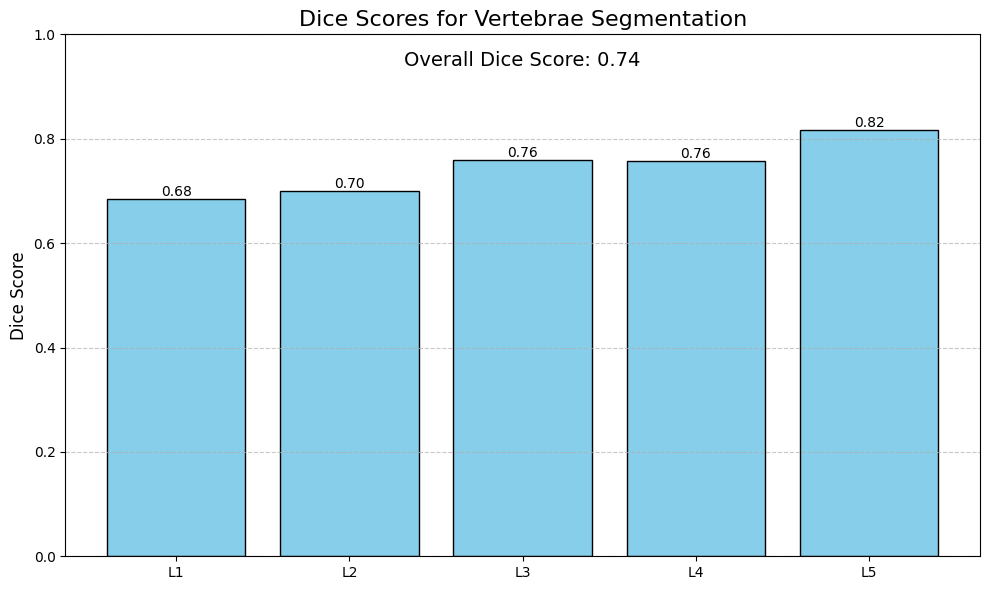

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

vertebrae_classes = ['L1', 'L2', 'L3', 'L4', 'L5']
dice_scores = (o_scores.tolist())[::-1][:-1]  
overall_score = np.mean(dice_scores)

# Create a simple bar plot for the Dice scores
figure=plt.figure(figsize=(10, 6))
bars = plt.bar(vertebrae_classes, dice_scores, color='skyblue', edgecolor='black')

# Annotate the bars with the Dice scores
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Add overall score as a separate text
plt.text(0.5, 0.95, f'Overall Dice Score: {overall_score:.2f}', ha='center', va='center', fontsize=14, transform=plt.gca().transAxes)

# Customize plot
plt.title('Dice Scores for Vertebrae Segmentation', fontsize=16)
plt.ylabel('Dice Score', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
figure.savefig('./dice_Scores.png')
# Display plot
plt.tight_layout()

plt.show()


# Inference on DCM Files 

In [17]:
import pydicom

In [18]:
model.load_state_dict(torch.load('/kaggle/working/simple_unet.pth'))

<All keys matched successfully>

torch.Size([1, 256, 256])


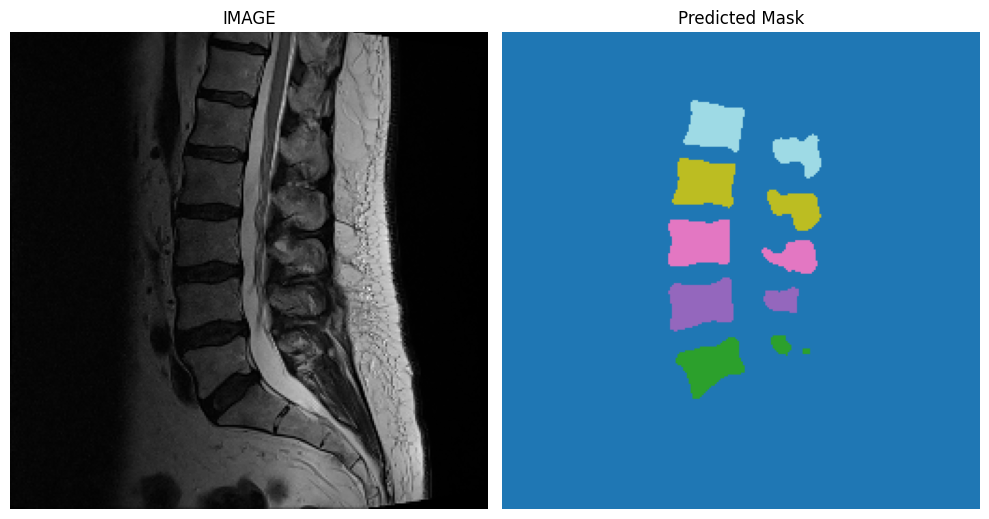

In [19]:
import torch
import numpy as np
import pydicom
import matplotlib.pyplot as plt

model.eval()
model.to(device)

# Define a color map with fixed colors for each label
def get_label_colors(num_classes):
    colors = plt.cm.tab20(np.linspace(0, 1, num_classes))
    return colors

figure=plt.figure(figsize=(10, 10))

label_colors = get_label_colors(num_classes)

file_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1028684462/2914428894/8.dcm'
im = pydicom.dcmread(file_path).pixel_array
im = im / 255.0
im = transforms_valid(image=im)['image']  
im = im.unsqueeze(0).float().to(device)  # Ensure the transformed image is sent to the device

with torch.no_grad():
    output = model(im)
    pred = torch.argmax(output, dim=1)
    im = im.squeeze(0).cpu()  # Remove the batch dimension and move to CPU for plotting
    pred = pred.squeeze(0).cpu()  # Squeeze and move to CPU

    # Plotting the original image
    plt.subplot(1, 2, 1)
    print(im.shape)
    im = np.transpose(im.numpy(), (1, 2, 0))  # Transpose to (H, W, C)
    im = ((im * 0.229) + 0.485) * 255  # Adjust normalization (ensure these values match your training)
    plt.imshow(im, cmap='gray')
    plt.title("IMAGE")
    plt.axis('off')

    # Plotting the predicted mask
    plt.subplot(1, 2, 2)
    mask = pred.numpy()  # Convert prediction to numpy

    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3))  # Initialize the color mask
    for label in range(num_classes):
        color_mask[mask == label] = label_colors[label][:3] * 255  # Apply the colors based on label

    plt.imshow(color_mask.astype(np.uint8))
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()
figure.savefig('./Prediction.png')

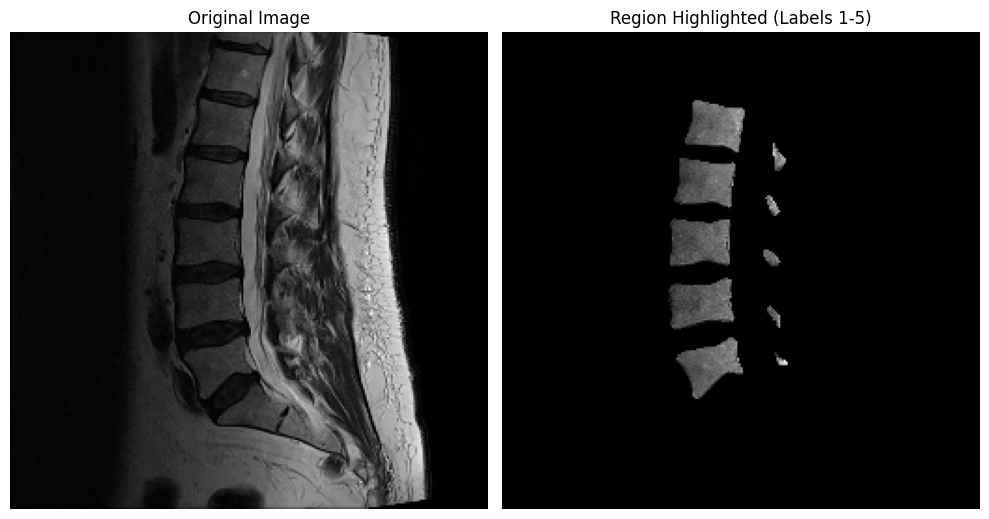

In [20]:
import torch
import numpy as np
import pydicom
import matplotlib.pyplot as plt

model.eval()
model.to(device)

# Define a color map with fixed colors for each label
def get_label_colors(num_classes):
    colors = plt.cm.tab20(np.linspace(0, 1, num_classes))
    return colors

figure=plt.figure(figsize=(10, 10))

label_colors = get_label_colors(num_classes)

file_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1028684462/2914428894/9.dcm'
im = pydicom.dcmread(file_path).pixel_array
im = im / 255.0
im = transforms_valid(image=im)['image']  # Assuming transforms_valid is already defined
im = im.unsqueeze(0).float().to(device)  # Ensure the transformed image is sent to the device

with torch.no_grad():
    output = model(im)
    pred = torch.argmax(output, dim=1)
    im = im.squeeze(0).cpu()  # Remove the batch dimension and move to CPU for plotting
    pred = pred.squeeze(0).cpu()  # Squeeze and move to CPU

    # Plotting the original image
    plt.subplot(1, 2, 1)
    im_np = np.transpose(im.numpy(), (1, 2, 0))  # Transpose to (H, W, C)
    im_np = ((im_np * 0.229) + 0.485) * 255  # Adjust normalization (ensure these values match your training)
    im_np = im_np  # Convert to uint8 for display
    plt.imshow(im_np, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Plotting the regions based on labels 1-5
    plt.subplot(1, 2, 2)
    combined_mask = np.zeros_like(im_np)  # Initialize a combined mask for all labels 1-5
    
    for label in range(1, 6):  # Loop through labels 1-5
        binary_mask = (pred.numpy() == label)  # Create a binary mask for the current label
        label_region = np.zeros_like(im_np)  # Initialize an empty image for the label region
        
        label_region[:, :,0] = im_np[:, :,0] * binary_mask

        # Add the label region to the combined mask
        combined_mask += label_region

    plt.imshow(combined_mask,cmap='gray')
    plt.title("Region Highlighted (Labels 1-5)")
    plt.axis('off')

plt.tight_layout()
figure.savefig('./demo.png')
plt.show()
